### Understanding the Data

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('telco.csv')

After loading the necessary packages, let's take a look at the data provided.

In [156]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


The dataset contains information on 7,043 telecommunications customers, capturing, service subscriptions, billing information, and churn behavior. It includes 33 columns, with a mix of categorical and numerical data. Key attributes include customer tenure, contract type, payment method, and churn indicators. 

### Remove Duplicate Data

First, we drop all duplicates rows from the DataFrame. Then, we determine the number of repeat customer ID's, in which duplicates will be removed if necessary.

In [157]:
# Remove for Duplicate Rows
df.drop_duplicates()
# Check for duplicate customer IDs
duplicates = df['CustomerID'].duplicated().sum()
print(f"Number of duplicate customerIDs: {duplicates}")


Number of duplicate customerIDs: 0


### Handle Missing Values

The data was reviewed to check how many missing values existed per column.

In [138]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

Most columns are complete, with the exception of the "Churn Reason" column, which is only applicable to customers who have already churned, hence the reason for the null values.

If the Churn Value was 0, and the Churn Reason was null, it was set to "Not Applicable".

In [158]:
### Create cleaned churn reason column
# If Churn == 0 and Churn Reason is null, set to "Not Applicable"
df['Churn Reason Cleaned'] = np.where(
    (df['Churn Value'] == 0) & (df['Churn Reason'].isna()),
    'Not Applicable',
    df['Churn Reason']
)


Customers with a tenure of 0 months had missing values in the Total Charges column. For consistency, these values were imputed as 0.

In [159]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df.loc[(df['Tenure Months'] == 0) & (df['Total Charges'].isna()), 'Total Charges'] = 0

### Handle and Detect Outliers

Box and whisker plots were used to detect the presence of outliers for the numeric columns, Monthly Charges, Total Charges, CLTV and Tenure Months. 

### Optimize Data Structure 

To facilitate analysis, categorical responses such as "No internet service" and "No phone service" were standardized and replaced with "No".

Additinally, churn reasons were grouped into broader, more interpretable categories.

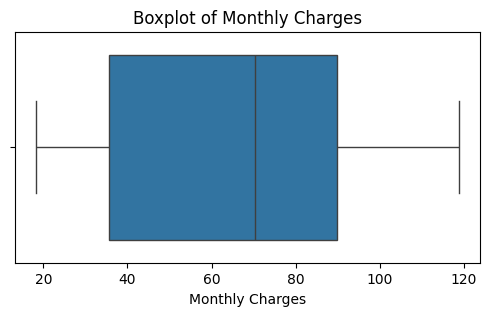

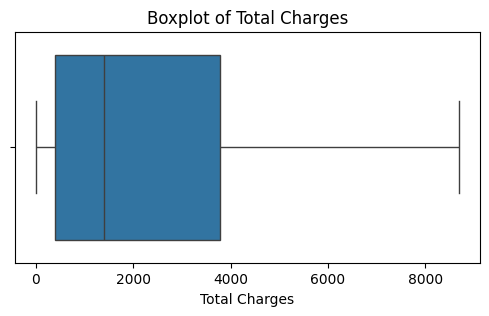

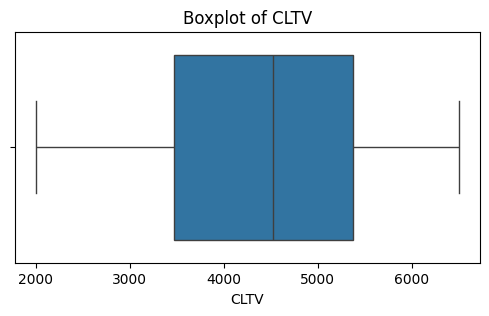

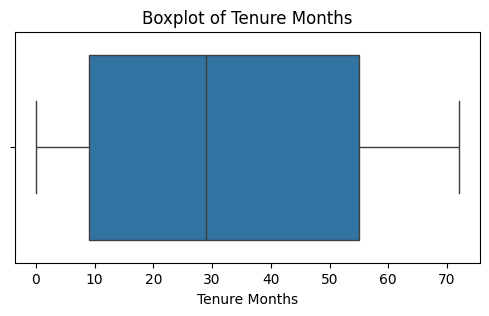


IQR Outlier counts:
Monthly Charges: 0 outliers
Total Charges: 0 outliers
CLTV: 0 outliers
Tenure Months: 0 outliers


In [161]:
key_columns = ['Monthly Charges', 'Total Charges', 'CLTV', 'Tenure Months']
outlier_counts = {}

for col in key_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = outliers.shape[0]

    # Boxplot
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

print("\nIQR Outlier counts:")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

In [160]:
### 5. Replace 'No internet service' with 'No' for certain columns
internet_service_cols = [
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]
df[internet_service_cols] = df[internet_service_cols].replace('No internet service', 'No')


### Replace 'No phone service' with 'No' for Multiple Lines column
multiple_lines_cols = ['Multiple Lines']
df[multiple_lines_cols] = df[multiple_lines_cols].replace('No phone service', 'No')    
    
    
### 6. Map cleaned churn reasons to broader categories
reason_map = {
    'Competitor made better offer': 'Competition',
    'Competitor had better devices': 'Competition',
    'Competitor offered higher download speeds': 'Competition',
    'Competitor offered more data': 'Competition',
    'Moved': 'Other',
    'Deceased': 'Other',
    "Don't know": 'Other',
    'Price too high': 'Pricing',
    'Extra data charges': 'Pricing',
    'Long distance charges': 'Pricing',
    'Product dissatisfaction': 'Service Issues',
    'Service dissatisfaction': 'Service Issues',
    'Network reliability': 'Service Issues',
    'Limited range of services': 'Service Issues',
    'Lack of affordable download/upload speed': 'Service Issues',
    'Lack of self-service on Website': 'Customer Service',
    'Poor expertise of online support': 'Customer Service',
    'Poor expertise of phone support': 'Customer Service',
    'Attitude of service provider': 'Customer Service',
    'Attitude of support person': 'Customer Service',
    'Not Applicable': 'Not Applicable'
}
df['Churn Reason Grouped'] = df['Churn Reason Cleaned'].map(reason_map)


### Create cleaned churn reason column
# If Churn == 0 and Churn Reason is null, set to "Not Applicable"
df['Churn Reason Cleaned'] = np.where(
    (df['Churn Value'] == 0) & (df['Churn Reason'].isna()),
    'Not Applicable',
    df['Churn Reason']
)


### Feature Engineering

Since raw data often doesn't capture the full story, Feature engineering was incorporated to enhance the data quality and provide a foundation of improved variables to use for further anlaysis.

In [172]:
# Feature Engineering
    


# Derived Feature 1 - Average Monthly Spend
df['Avg Monthly Spend'] = np.where(
    df['Tenure Months'] > 0,
    df['Total Charges'] / df['Tenure Months'],
    df['Total Charges']
)

# Derived Feature 2- High Value Customer as Yes/No
cltv_75 = df['CLTV'].quantile(0.75)
df['High Value Customer'] = np.where(df['CLTV'] > cltv_75, 'Yes', 'No')

# Derived Feature 3 - Short Term, Medium Term, and Long Term Customer
df['Customer Tenure Group'] = pd.cut(
    df['Tenure Months'],
    bins=[0, 12, 48, 72],
    labels=['Short Term', 'Medium Term', 'Long Term'],
    include_lowest=True
)

# Derived Feature 4: Service Utilization

# Define service columns with Yes/No values
service_cols = [
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

# Count how many services are "Yes"
df['Num Services Used'] = df[service_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

# Classify as "Multiple" if more than 2 services, else "Few"
df['Service Utilization'] = np.where(df['Num Services Used'] > 2, 'Multiple', 'Few')


# Derived Feature 5: To consolidate Streaming Services under one binary variable
df['Streaming Services'] = df.apply(
    lambda row: 'Yes' if (row['Streaming TV'] == 'Yes' or row['Streaming Movies'] == 'Yes') else 'No',
    axis=1
)

# Derived Feature 6: A feature to isolate the electronic Check User, a customer with a high chance of churn
import pandas as pd
df['Electronic Check User'] = df['Payment Method'].apply(lambda x: 1 if x == 'Electronic check' else 0)


# Derived Feature 7: Create a feature for payment methods that suggest automated billing:
autopay_methods = ['Bank transfer (automatic)', 'Credit card (automatic)']
df['Autopay User'] = df['Payment Method'].apply(lambda x: 1 if x in autopay_methods else 0)

# Derived Feature 8: A feature to measure the amount of support a customer has:
df['Support Score'] = df[['Tech Support', 'Device Protection', 'Online Security']].apply(lambda row: sum(row == 'Yes'), axis=1)

### Finalization of the dataset

For the purposes of EDA, the data cleaning and pre-processing is now complete.

In [176]:
# Final Handling of the dataset
desired_order = [
    'CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude',
    'Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service',
    'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
    'Contract', 'Paperless Billing', 'Payment Method', 'Tenure Months', 'Monthly Charges', 'Total Charges',
    'Avg Monthly Spend', 'Churn Score', 'Churn Label', 'Churn Value', 'CLTV', 'Customer Tenure Group',
    'High Value Customer', 'Service Utilization','Churn Reason', 'Churn Reason Cleaned', 'Churn Reason Grouped', 'Streaming Services', 'Electronic Check User',
    'Autopay User', 'Support Score'
]

# Reorder the DataFrame
df = df[desired_order]


### 10. Export cleaned data to CSV
df.to_csv('EDA_telco_data_v2.csv', index=False)
print("Cleaned data has been saved to 'EDA_telco_data_v2.csv'")

Cleaned data has been saved to 'EDA_telco_data_v2.csv'


### EDA (Exploratory Data Analysis)

Exploratory Data Analysis (EDA) is an important initial step in any data analysis undertaking. It involves examining the dataset to uncover underlying patterns, detect anomalies or outliers, and identify relationships between variables. Through summary statistics and visualizations, EDA helps analysts gain a deeper understanding of the data’s structure and quality. This process not only highlights unexpected features or inconsistencies in the data but also informs important decisions about data cleaning, feature selection, and transformation.EDA lays the groundwork for more effective model building by ensuring that the data is well-understood and appropriately prepared.

In [146]:
df.describe(include='all')  # 'include="all"' gives stats for both numeric and categorical

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Churn Score,Churn Label,Churn Value,CLTV,Customer Tenure Group,High Value Customer,Service Utilization,Churn Reason,Churn Reason Cleaned,Churn Reason Grouped
count,7043,7043.0,7043,7043,7043,7043.000000,7043,7043.000000,7043.000000,7043,...,7043.000000,7043,7043.000000,7043.000000,7043,7043,7043,1869,7043,7043
unique,7043,NaN,1,1,1129,NaN,1652,NaN,NaN,2,...,NaN,2,NaN,NaN,3,2,2,20,21,6
top,3186-AJIEK,NaN,United States,California,Los Angeles,NaN,"34.159534, -116.425984",NaN,NaN,Male,...,NaN,No,NaN,NaN,Medium Term,No,Few,Attitude of support person,Not Applicable,Not Applicable
freq,1,NaN,7043,7043,305,NaN,5,NaN,NaN,3555,...,NaN,5174,NaN,NaN,2618,5282,4218,192,5174,5174
mean,NaN,1.0,NaN,NaN,NaN,93521.964646,NaN,36.282441,-119.798880,NaN,...,58.699418,NaN,0.265370,4400.295755,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,1865.794555,NaN,2.455723,2.157889,NaN,...,21.525131,NaN,0.441561,1183.057152,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.0,NaN,NaN,NaN,90001.000000,NaN,32.555828,-124.301372,NaN,...,5.000000,NaN,0.000000,2003.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.0,NaN,NaN,NaN,92102.000000,NaN,34.030915,-121.815412,NaN,...,40.000000,NaN,0.000000,3469.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.0,NaN,NaN,NaN,93552.000000,NaN,36.391777,-119.730885,NaN,...,61.000000,NaN,0.000000,4527.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.0,NaN,NaN,NaN,95351.000000,NaN,38.224869,-118.043237,NaN,...,75.000000,NaN,1.000000,5380.500000,NaN,NaN,NaN,NaN,NaN,NaN


The describe function provides initial insights into the data provided. From the mean column of statistics, it is observed that most of the customers are male, more customers remained with the company than stayed. Interestingly, it was noted also that the main reason for leaving was the attitude of the support person. Further visualizations will be create as we continue to explore dataset.

In [164]:
df['Churn Value'].value_counts(normalize=True)


Churn Value
0    0.73463
1    0.26537
Name: proportion, dtype: float64

C:\Users\cyrus\AppData\Local\Temp\ipykernel_13980\3871829984.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Churn Label', palette=palette)


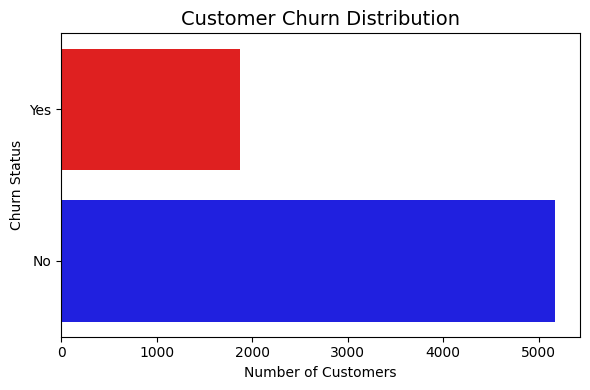

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color palette
palette = {'Yes': 'red', 'No': 'blue'}

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df, y='Churn Label', palette=palette)

# Title and labels
plt.title('Customer Churn Distribution', fontsize=14)
plt.xlabel('Number of Customers')
plt.ylabel('Churn Status')

plt.tight_layout()
plt.show()


The results indicate a churn rate of 26.5%. While this is a relatively high proportion, it may require the use of class balancing techniques—such as SMOTE or undersampling—during model development to ensure robust predictive performance.

In [166]:
# Get counts and proportions
churn_counts = df['Churn Label'].value_counts()
churn_props = df['Churn Label'].value_counts(normalize=True).round(3)

# Combine into one DataFrame
churn_summary = pd.DataFrame({
    'Count': churn_counts,
    'Proportion': churn_props
})

churn_summary

,Count,Proportion
Churn Label,,
No,5174,0.735
Yes,1869,0.265


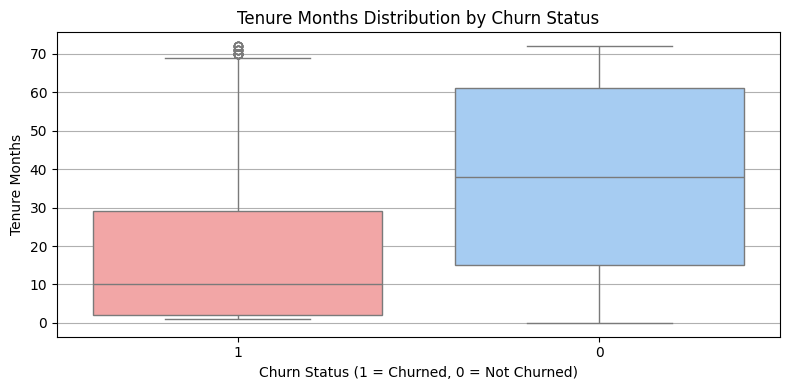

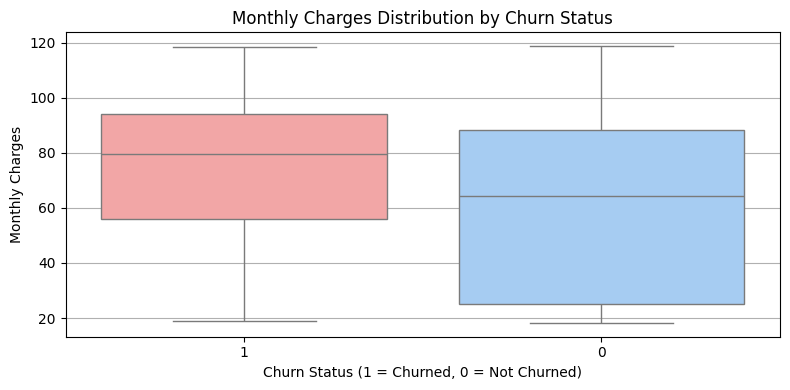

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['Tenure Months', 'Monthly Charges']
palette = {0: '#99CCFF', 1: '#FF9999'}  # 0 = Not Churned, 1 = Churned

for col in cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(
        data=df,
        x='Churn Value',
        y=col,
        hue='Churn Value',
        palette=palette,
        order=[1, 0],     # Churned on left, Not Churned on right
        legend=False
    )
    plt.title(f'{col} Distribution by Churn Status')
    plt.xlabel('Churn Status (1 = Churned, 0 = Not Churned)')
    plt.ylabel(col)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


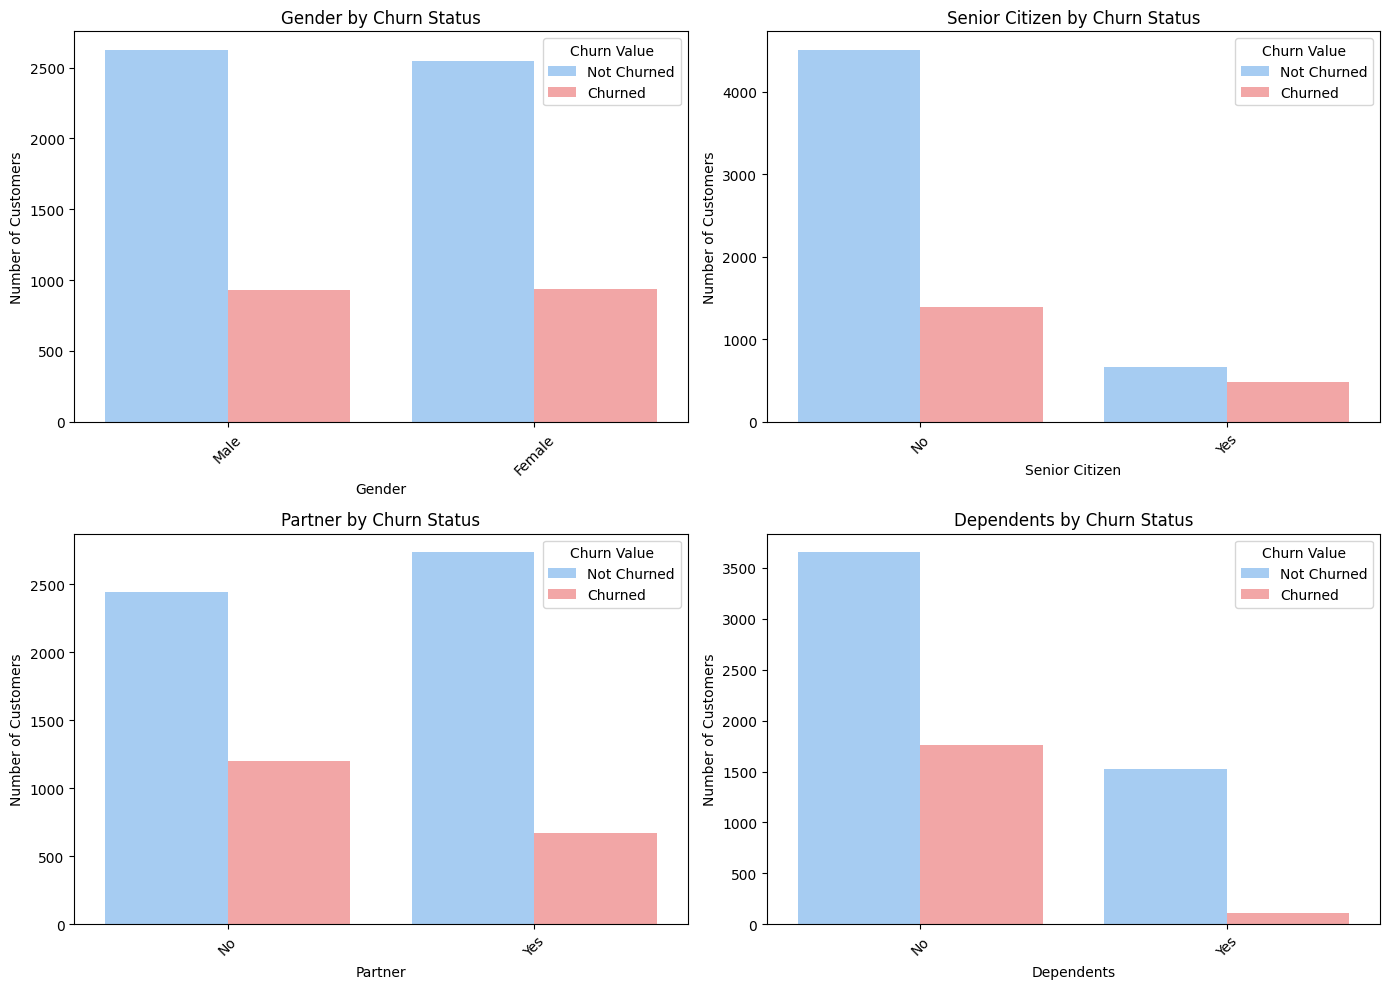

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

# Personal Details
variables = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']

# Define light color palette: 1 = churned (light red), 0 = not churned (light blue)
palette = {1: '#FF9999', 0: '#99CCFF'}

# Set up the grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through variables and create a countplot on each subplot
for i, var in enumerate(variables):
    sns.countplot(data=df, x=var, hue='Churn Value', ax=axes[i], palette=palette)
    axes[i].set_title(f'{var} by Churn Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Number of Customers')
    axes[i].legend(title='Churn Value', labels=['Not Churned', 'Churned'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Impact of Personal Details on Churn

When observing the bar graphs of personal details that influence churn, Gender does not appear to influence customer churn, as both male and female reflect similar figure of retention and churn. Although, there are fewer senior citizen customers, a larger proprotion of them churn, which may suggest cost senstivity, lower tech adoption or less need for the service. Customers without a partner are more likely to churn. Having a partner may mean greater household stability, and couples normally share services, which may explain the increased churn rate. Additionally, customers with dependents churn less, as they may have greater stability and more consistent need for the sake of their children, for instance. Senior Citizen, Partner and Dependents show noticeable churn differences which can potentially be useful features in predictive models.

### Impact of Streaming Services on Churn

In both plots, a larger portion of churned customer do not use these services but there are still churners among those who do not stream. Having streaming services does not guarantee retention but customers with no streaming services churn more frequently. This may mean that having customers subsribed to additional services might increase rentention.

A new feature such as streaming services can be dervied from these columns, as it simplies two related features into one useful binary feature and captures general interest in streaming regardless of the type. 


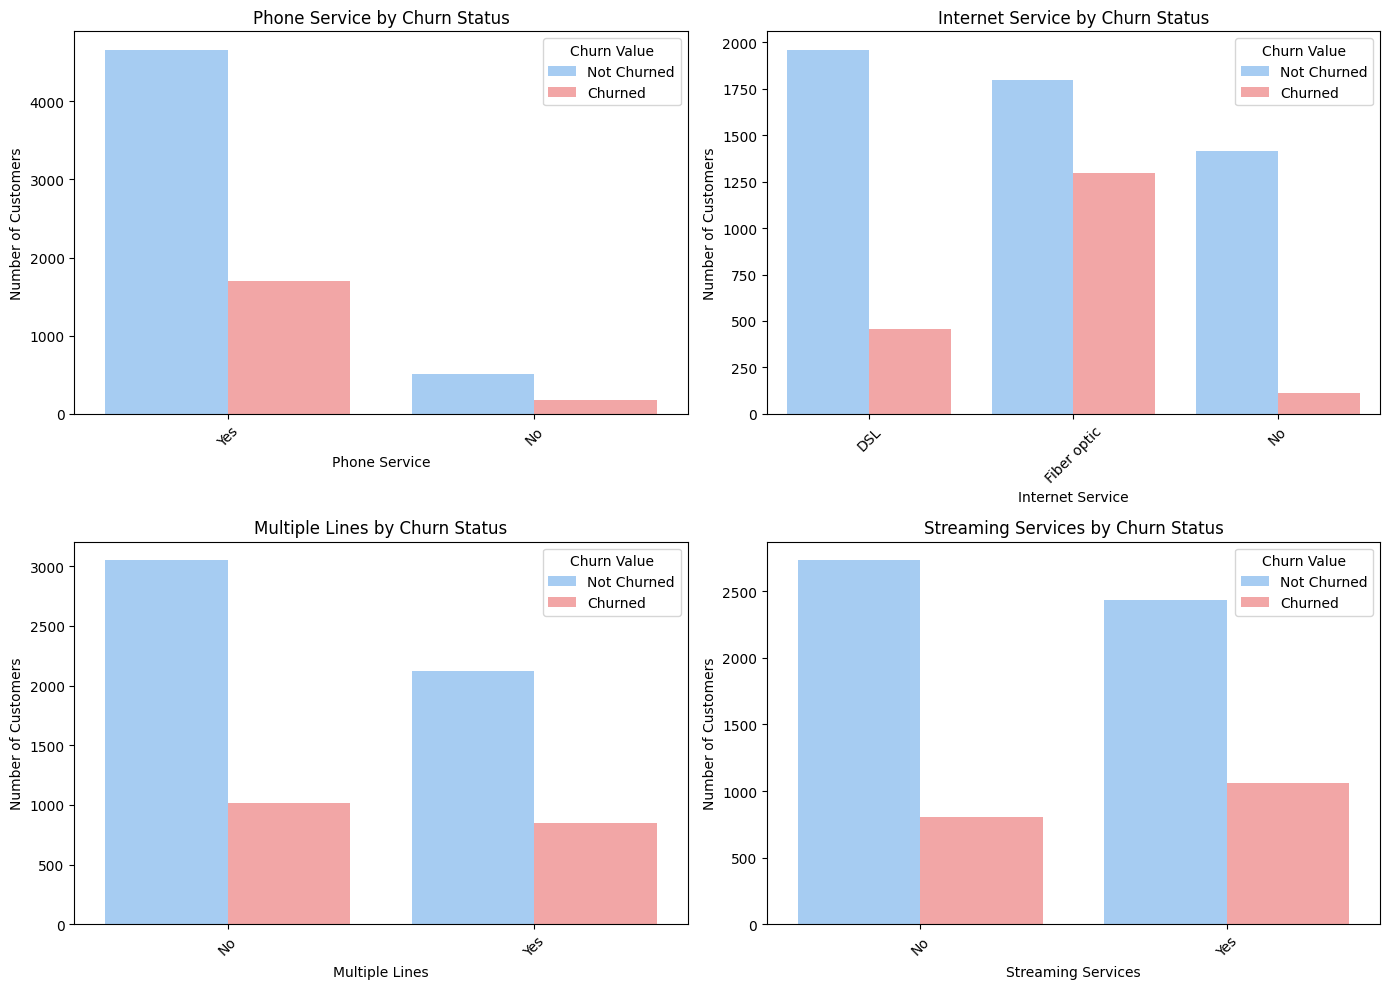

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# Services
variables = ['Phone Service', 'Internet Service', 'Multiple Lines', 'Streaming Services']

# Define light color palette: 1 = churned (light red), 0 = not churned (light blue)
palette = {1: '#FF9999', 0: '#99CCFF'}

# Set up the grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns
axes = axes.flatten()

# Loop through variables and create a countplot on each subplot
for i, var in enumerate(variables):
    sns.countplot(data=df, x=var, hue='Churn Value', ax=axes[i], palette=palette)
    axes[i].set_title(f'{var} by Churn Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Number of Customers')
    axes[i].legend(title='Churn Value', labels=['Not Churned', 'Churned'])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Impact of Services on Churn

Whilst the majority of customers have phone services, there is a notable amount of churn between both groups. In this case phone service may not be a major differentiator for churn. 
Pertaining to internet service, customers with fibre optic internet have the highest churn rate. This may suggest that fibre optic customers are more demanding and more likely to churn if dissatisfied with the service. 
Both groups of customers with and without multiple lines show churn but customer with multiple lines churn a bit less frequently, as they may be more invested in the service.
Customers without streaming services actually churn at a lower rate than those who do not, which may suggest that these individuals may be on  higher-tier plans and are likely to churn faster when disappointed. 


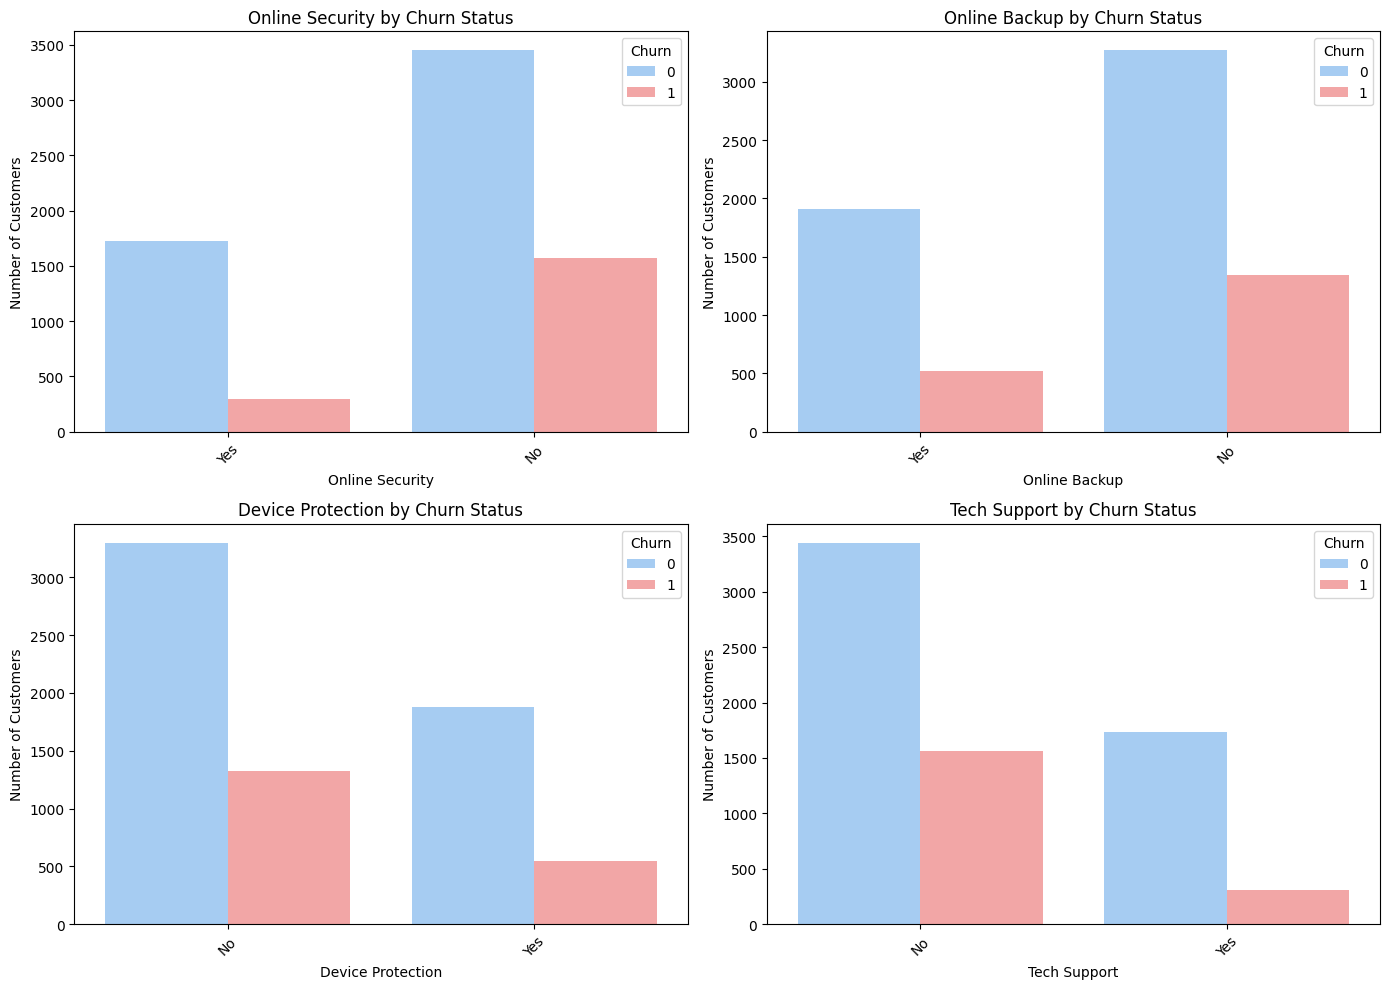

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

# Services
variables = ['Online Security','Online Backup','Device Protection','Tech Support']
# Set up the grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns

palette = {1: '#FF9999', 0: '#99CCFF'}


# Flatten axes to easily loop through
axes = axes.flatten()

# Loop through variables and create a countplot on each subplot
for i, var in enumerate(variables):
    sns.countplot(data=df, x=var, hue='Churn Value', ax=axes[i],palette=palette)
    axes[i].set_title(f'{var} by Churn Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Number of Customers')
    axes[i].legend(title='Churn')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Impact of Value Added Services on Churn

The results of the four graphs consistently demonstrate that customers who subscribe to these extra value services are consistently less likely to churn. Having one or more of these services appear to improve the customer experience and tie customers more closely to the provider. This also presents a feature engineering opportunity that can be explored, "Value Service Count".


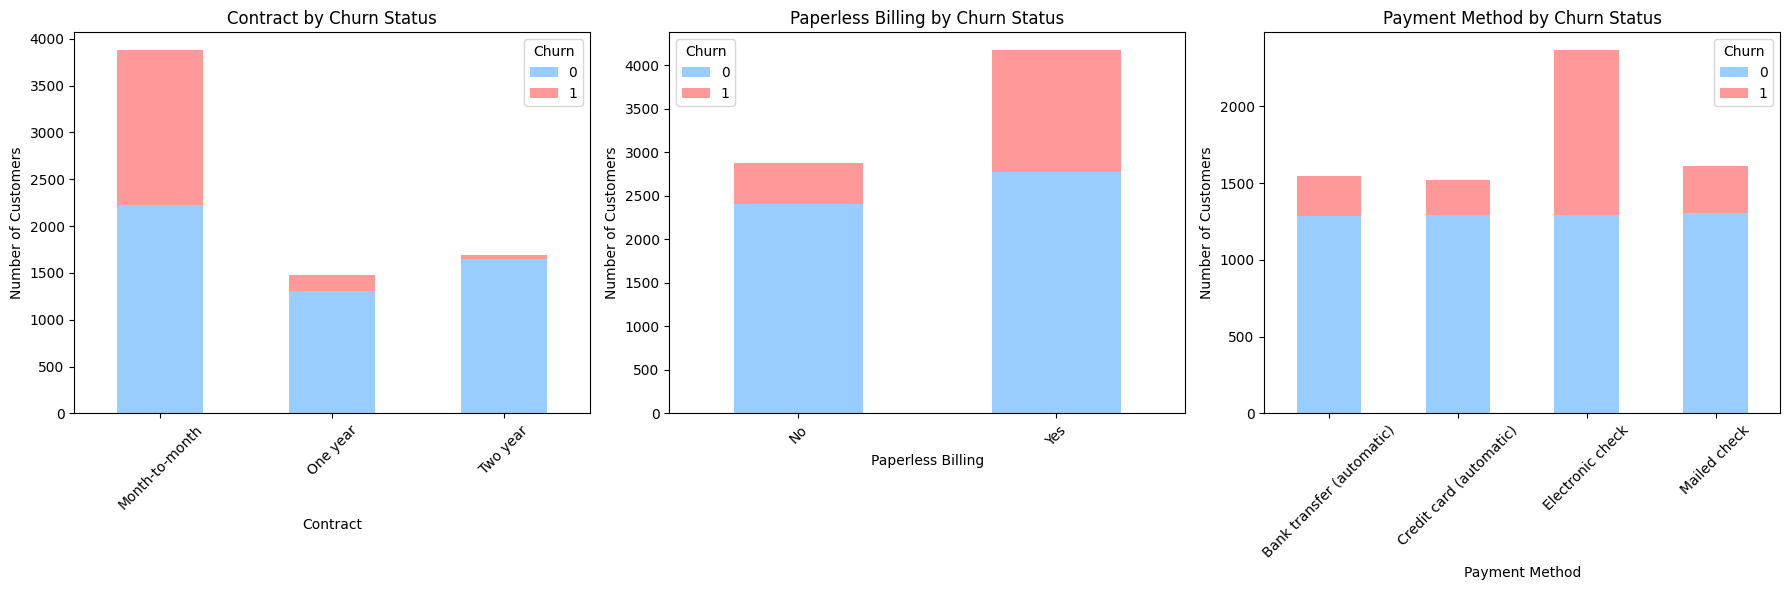

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# Define variables and color palette
variables = ['Contract', 'Paperless Billing', 'Payment Method']
palette = {1: '#FF9999', 0: '#99CCFF'}

# Set up the grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each variable to plot stacked bar charts
for i, var in enumerate(variables):
    # Group and reshape the data
    counts = df.groupby([var, 'Churn Value']).size().unstack(fill_value=0)
    
    # Plot stacked bars
    counts[[0, 1]].plot(kind='bar', stacked=True, ax=axes[i], color=palette)
    
    # Titles and labels
    axes[i].set_title(f'{var} by Churn Status')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Number of Customers')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()


### Impact of Payment Details on Churn

Based on the graphs produced, month-to-month customers have the highest churn by far, suggesting that they are less committed and likely to switch providers easily. A longer contract signifiicantly reduces the churn rate.

Customers with paperless billing churn more with those without it. This may be because customers accessing this method may be younger and more tech savvy who would be more willing to switch providers for greater perceived value. 

Electronic cehck users have much higher churn than any other group. These manual payment users may be less committed, and tend to delay or cancel payments more easily. On the other hand, customers using automatic payment methods, whether it may be bank or credit transfer, tend to be more stable and less likely to churn.

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt


# Filter out "Not Applicable" 
filtered_df = df[df['Churn Reason Grouped'] != 'Not Applicable']

# Get value counts and percentages
reason_counts = filtered_df['Churn Reason Grouped'].value_counts()
reason_percent = filtered_df['Churn Reason Grouped'].value_counts(normalize=True) * 100

# Combine into a DataFrame
churn_reason_table = pd.DataFrame({
    'Count': reason_counts,
    'Percentage (%)': reason_percent.round(2)
})

# Display table
churn_reason_table.reset_index(inplace=True)
churn_reason_table.rename(columns={'index': 'Churn Reason Grouped'}, inplace=True)

# Show the table
print(churn_reason_table)





  Churn Reason Grouped  Count  Percentage (%)
0          Competition    621           33.23
1     Customer Service    454           24.29
2       Service Issues    382           20.44
3                Other    213           11.40
4              Pricing    199           10.65


In [131]:
# Filter out "Not Applicable" 
filtered_df = df[df['Churn Reason Cleaned'] != 'Not Applicable']

# Get value counts and percentages
reason_counts = filtered_df['Churn Reason Cleaned'].value_counts()
reason_percent = filtered_df['Churn Reason Cleaned'].value_counts(normalize=True) * 100

# Combine into a DataFrame
churn_reason_table = pd.DataFrame({
    'Count': reason_counts,
    'Percentage (%)': reason_percent.round(2)
})

# Display table
churn_reason_table.reset_index(inplace=True)
churn_reason_table.rename(columns={'index': 'Churn Reason'}, inplace=True)

# Show the table
print(churn_reason_table)


                         Churn Reason Cleaned  Count  Percentage (%)
0                  Attitude of support person    192           10.27
1   Competitor offered higher download speeds    189           10.11
2                Competitor offered more data    162            8.67
3                                  Don't know    154            8.24
4                Competitor made better offer    140            7.49
5                Attitude of service provider    135            7.22
6               Competitor had better devices    130            6.96
7                         Network reliability    103            5.51
8                     Product dissatisfaction    102            5.46
9                              Price too high     98            5.24
10                    Service dissatisfaction     89            4.76
11            Lack of self-service on Website     88            4.71
12                         Extra data charges     57            3.05
13                                

### Customer Churn Reasons

At a high level, the grouped summary indciated that the top drivers of churn were competition (33%), customer service (24%), and service issues (20%), which account for 78% of all churn, highlighting their significance in contributing to customer churn.

When digging deeper into the specific details, it is evidenced that more than half of customers left due to either compelling proposition from competitors or dissatisfaction with customer support. Customers cited more data plans, better download speeds, or more attractive pricing from competitors, while others made mention of poor attitude from support personnel.

These insights suggest that churn is largely preventable. Improving the customer service experience and proposing competitive subscription packages will undoubtedly assist in improving retention. 

# Data Preprocessing for Machine Learning


*Once the initial cleaning and preprocessing steps were completed, further preprocessing techniques were applied to prepare the data for the deployment of advanced machine learning models*

1) Label Encoding: Applied the LabelEnconder to convert binary features such as Gender, Senior Citizen, Partner, Dependents, 
   Phone Service and Paperless Billing.

2) One Hot Coding: One-hot coding was performed for columns such as Internet Service, Contract, Payment Method and Churn Reason Grouped. This created dummy variables to represent each category.

3) Feature Scaling: Applied StandardScaler to Tenure Months, Monthly Charges and Total Charges, which are new columns with zero 
   mean and unit variance to help scale-sensitive models.

4) Target/Feature Separation: Dropped irrelevant columns such as CustomerID, Latitude, Longitude columns and any other text 
   based columns.

5) SMOTE - Applied the Synthetic Minority Over-sampling Technique to balance the dataset by generating synthetic samples for  
   the minority class where Churn = 1.

6) Class Weight Calculation: Computed weights so that they could be passed into ML models to emphasize the minority class 
   during training. 